*UID*: 118775876, 119207666, 118495965


# **CMSC426 Project 3: Feature Tracking and Structure from Motion**

# Feature Tracking
In the problem, you will implement a corner detector and feature tracker that track features from the image sequence taxi.

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

import scipy.io as sio
# !pip install git+https://github.com/Guillem96/spynet-pytorch
# Download training images from Google Drive
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = sio.loadmat('/content/Part2_data/tracks.mat')

Downloading...
From: https://drive.google.com/uc?id=1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
To: /content/Part2_data.zip
100% 5.44M/5.44M [00:00<00:00, 236MB/s]
Archive:  /content/Part2_data.zip
replace /content/Part2_data/images/hotel.seq0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Part2_data/images/hotel.seq0.png  
  inflating: /content/Part2_data/images/hotel.seq1.png  
  inflating: /content/Part2_data/images/hotel.seq10.png  
  inflating: /content/Part2_data/images/hotel.seq11.png  
  inflating: /content/Part2_data/images/hotel.seq12.png  
  inflating: /content/Part2_data/images/hotel.seq13.png  
  inflating: /content/Part2_data/images/hotel.seq14.png  
  inflating: /content/Part2_data/images/hotel.seq15.png  
  inflating: /content/Part2_data/images/hotel.seq16.png  
  inflating: /content/Part2_data/images/hotel.seq17.png  
  inflating: /content/Part2_data/images/hotel.seq18.png  
  inflating: /content/Part2_data/images/hotel.seq19.png  
  inflating: /content/Part2

### Check the dataset

Number of frames: 51


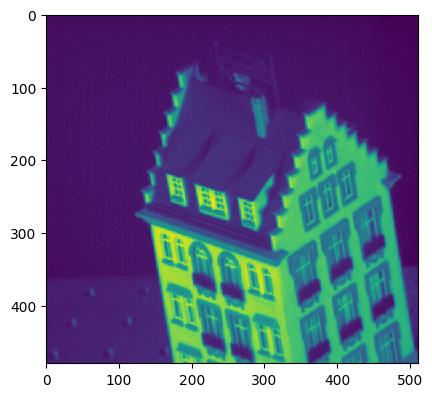

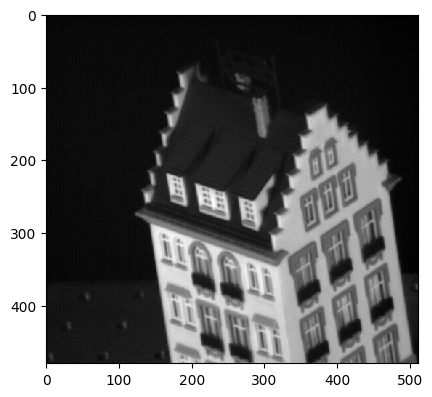

In [ ]:
from pathlib import Path
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

img_fnames = sorted(list(Path('/content/Part2_data/images/').iterdir()))
print(f'Number of frames: {len(img_fnames)}')

img1 = Image.open(img_fnames[20])
img2 = Image.open(img_fnames[22])

plt.figure(figsize=1.0* plt.figaspect(1))
plt.imshow(img1, interpolation='nearest')
plt.figure(figsize=1.0* plt.figaspect(1))
plt.imshow(img2, interpolation='nearest')
plt.gray()
# plt.axis('off')
plt.show()

### Helper Function

In [ ]:
# Check whether the training images were successfully imported
import matplotlib.pyplot as plt
import numpy as np
import cv2

'''
    inRange checks whether the given cordinates line in the given image limits
 cordinates, limits are tuples i.e., (X,Y)
'''
def inRange( cordinates, limits):
	x,y = cordinates
	X_Limit, Y_Limit = limits
	return 0 <= x and x < X_Limit and 0 <= y and y < Y_Limit

def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray()
    plt.axis('off')
    plt.show()


### Keypoint Selection (5 pts)

For the first frame, use function cv2.goodFeaturesToTrack to extract keypoints. These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold to selection >100 keypoints.

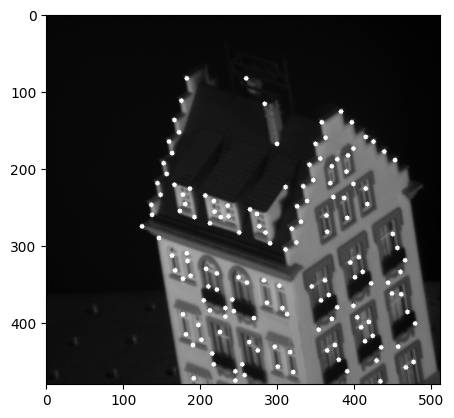

In [ ]:
# Given an image, return the extracted key points
def getKeypoints(img):
  '''
  output: (N,2) array of [x,y] keypoints
  '''


  # Use goodFeaturesToTrack to extract key points
  features = cv2.goodFeaturesToTrack(img, maxCorners=150, qualityLevel=0.01, minDistance=10)

  # Postpone the output into the correct format
  features = np.int0(features)
  features_list = np.squeeze(features)

  return features_list

# Load in a sample image and extract the keypoints
img1 = np.array(Image.open(img_fnames[20]))
keypoints = getKeypoints(img1)

# Iterate over the keypoints and add them to the image
for i in keypoints:
    x,y = i.ravel()
    cv.circle(img1,(x,y),3,255,-1)

# Visualize the keypoints and the original image
plt.imshow(img1)
plt.show()

# https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541

### Optical Flow  (15 pts)

Optical Flow is technique used to extract motion from multiple images, in practice we usually use only two frames of a video.

Optical flow is based on the Brightness consistency assumtion. The intensity in location $(x, y)$ at time $t$ is almost equal at time $t + 1$.

$ f(x, y, t) = f(x + dx, y + dy, t + 1) $

$(dx, dy) = (u, v)$

With taylor series we can express the equation above as follows

$ f_x u + f_y v + f_t = 0 $

Above equation is called Optical Flow equation. In it, we can find $f_x$ and $f_y$, they are image gradients. Similarly $f_t$ is the gradient along time. But $(u,v$) is unknown. We cannot solve this one equation with two unknown variables. So several methods are provided to solve this problem:

- Discrete optimization methods
- Differential methods such as: [Lucas-kanade](http://cseweb.ucsd.edu/classes/sp02/cse252/lucaskanade81.pdf) and [Horn–Schunck](http://dspace.mit.edu/handle/1721.1/6337)

With Optical Flow, we compute a motion vector $(u, v)$ which encodes de displacement in $x$ and $y$ directions betwween two consecutive frames.

#### Apply the Lucas-kanade algorithm
Apply the Lucas-kanade algorithm to track the keypoints found above

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section.

In [ ]:
'''
    opticalFlow calculates the displacements in X and Y directions i.e., (u,v)
    given two consecutive images varying with time
'''
import numpy as np
from scipy.ndimage import convolve

# Helper function to make the range of the pixel values to be from 0 to 1
def normalize_image(image):
    return image/255


# Compute the change in intensity in the x and y direction
def image_derivatives(image):
    # Define the sobel operators to compute x and y derivatives
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Apply the x and y sobel operators to get the change in intensity
    # in the x and y direction
    Ix = convolve(image, sobel_x)
    Iy = convolve(image, sobel_y)

    return Ix, Iy

# Implementation of the Lucas Kanade Algorithm
def lucas_kanade(Ix, Iy, It, window_size):
    half_size = window_size // 2

    Ix_squared = Ix**2
    Iy_squared = Iy**2
    IxIy = Ix * Iy
    Ixt = Ix * It
    Iyt = Iy * It

    # Sum over the window
    Ix_squared_sum = np.sum(Ix_squared)
    Iy_squared_sum = np.sum(Iy_squared)
    IxIy_sum = np.sum(IxIy)
    Ixt_sum = np.sum(Ixt)
    Iyt_sum = np.sum(Iyt)

    det = Ix_squared_sum * Iy_squared_sum - IxIy_sum**2
    det = max(det, 1e-6)  # Avoid division by zero

    u = (Iy_squared_sum * Ixt_sum - IxIy_sum * Iyt_sum) / det
    v = (IxIy_sum * Ixt_sum - Ix_squared_sum * Iyt_sum) / det

    return u, v

# This helper function adds padding to an image
def pad_image(image, window_size):
    # Pad Ix on the left and right
    half_size = window_size // 2
    padded = np.pad(image, ((0, 0), (half_size, half_size)), mode='constant', constant_values=0)
    return padded

# Implements the algorihm in the image
def optical_flow(old_frame, new_frame, window_size, keypoints):
    old_frame_normalized = normalize_image(old_frame)
    new_frame_normalized = normalize_image(new_frame)
    old_frame_padded = pad_image(old_frame_normalized, window_size * 2)
    new_frame_padded = pad_image(new_frame_normalized, window_size * 2)
    height, width = old_frame_normalized.shape

    # Compute image derivatives over the entire image
    Ix, Iy = image_derivatives(old_frame_normalized)

    # Pad Ix and Iy
    Ix_padded = pad_image(Ix, window_size*2)
    Iy_padded = pad_image(Iy, window_size*2)

    flow = np.zeros((width, height, 2))
    new_keypoints = []
    for (float_x, float_y) in keypoints:

        if not ((0 <= float_x) and (float_x <= width - 1) and (0 <= float_y) and (float_y <= height - 1)):
            new_keypoints.append((-1, -1))

        else:

          x, y = int(float_x), int(float_y)
          # Extract subarrays of precomputed image derivatives
          window_Ix = Ix_padded[y+window_size:y + 2 * window_size, x + window_size:x + 2*window_size]
          window_Iy = Iy_padded[y+window_size:y + 2*window_size, x + window_size:x + 2*window_size]
          window_old = old_frame_padded[y+window_size:y + 2 * window_size, x + window_size:x + 2*window_size]
          window_new = new_frame_padded[y+window_size:y + 2*window_size, x + window_size:x + 2*window_size]
          It = window_new - window_old

          u, v = lucas_kanade(window_Ix, window_Iy, It, window_size)
          flow[x, y, 0] = np.mean(u)
          flow[x, y, 1] = np.mean(v)
          new_keypoints.append((float_x + 10*u, float_y - 10*v))

    return flow, new_keypoints


### Visulize your result (10 pts)

Choose two images, calculate the LK optical flow and visulize it.

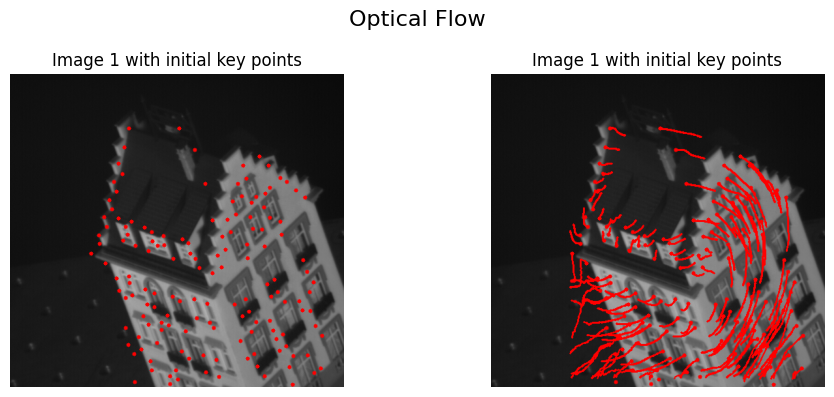

In [ ]:
# We will use the key points from the key point selection part above as
# a starting point
current_keypoints = keypoints
window_size = 15
keypoint_paths = [current_keypoints]
path = "/content/Part2_data/images/hotel.seq{number}.png"

for i in range(1, 51):
  # Load in the current and prev image based on the index number
  prev_img_path = path.format(number=i-1)
  curr_img_path = path.format(number=i)
  prev_img = cv2.imread(prev_img_path)
  curr_img = cv2.imread(curr_img_path)
  prev_img_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
  curr_img_gray = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)

  # Compute the optical flow based on the current and previous image
  current_flow, current_keypoints = optical_flow(prev_img_gray, curr_img_gray, window_size, current_keypoints)
  keypoint_paths.append(current_keypoints)
keypoint_paths = np.array(keypoint_paths)

# Visual the output
img1 = cv2.imread("/content/Part2_data/images/hotel.seq0.png")
img2 = cv2.imread("/content/Part2_data/images/hotel.seq50.png")
height, width, _ = img1.shape
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the key points of the first image on the left
ax1.set_title('Image 1 with initial key points')
for i in keypoints:
    x,y = i.ravel()
    cv.circle(img1,(x,y),3,255,-1)
ax1.imshow(img1)
ax1.axis('off')

# Plot the optical flow on the right
ax2.set_title('Image 1 with initial key points')
reshaped_keypoints = np.transpose(keypoint_paths, (1, 0, 2))
for point in range(len(reshaped_keypoints)):
  x_coords = reshaped_keypoints[point, :, 0]
  y_coords = reshaped_keypoints[point, :, 1]
  for i in range(len(x_coords) - 1):
    start_point = (int(x_coords[i]), int(y_coords[i]))
    end_point = (int(x_coords[i + 1]), int(y_coords[i + 1]))
    color = (255, 0, 0)
    thickness = 2
    img1 = cv2.line(img1, start_point, end_point, color, thickness)
ax2.imshow(img1, cmap='gray')
ax2.axis('off')

fig.suptitle('Optical Flow', fontsize=16)
plt.tight_layout()
plt.show()

# Structure from Motion from Two Views

Structure from motion (SfM) is the process of estimating the 3-D structure of a scene from a set of 2-D images. This question ask you to estimate the poses of a calibrated camera from two images, reconstruct the 3-D structure of the scene up to an unknown scale factor, and then recover the actual scale factor by detecting an object of a known size. You can find an example here: https://www.mathworks.com/help/vision/ug/structure-from-motion-from-two-views.html

### Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
import scipy.io as sio

# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = sio.loadmat('/content/Part2_data/tracks.mat')

Downloading...
From: https://drive.google.com/uc?id=1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
To: /content/Part2_data.zip
100% 5.44M/5.44M [00:00<00:00, 34.4MB/s]
Archive:  /content/Part2_data.zip
replace /content/Part2_data/images/hotel.seq0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Read a Pair of Images and Get Matched Points (5 pts)

Go through the dataset and choose two images with different views, you are free to pick any two images. Then get the matched points between them from the data.

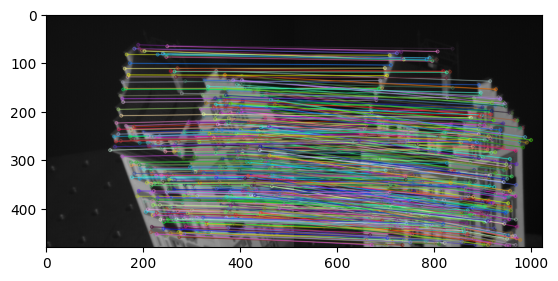

In [ ]:
import os

# Specify the indices of the pair of images you would like to analyze
img1_idx = 0
img2_idx = 49

# Given the indices, find their corresponding filenames
dir = "Part2_data/images/"
filename_prefix = f"hotel.seq"
filename_postfix = f".png"
img1_name = f"{filename_prefix}{img1_idx}{filename_postfix}"
img2_name = f"{filename_prefix}{img2_idx}{filename_postfix}"
img1_file = os.path.join(dir, img1_name)
img2_file = os.path.join(dir, img2_name)

# Load in the images and their given matched points
img1 = cv2.imread(img1_file)
img2 = cv2.imread(img2_file)
imagePoints1_x = data['track_x'][:, img1_idx]
imagePoints1_y = data['track_y'][:, img1_idx]
imagePoints2_x = data['track_x'][:, img2_idx]
imagePoints2_y = data['track_y'][:, img2_idx]

# Get the matches from /content/Part2_data/tracks.mat
imagePoints1 = np.column_stack((imagePoints1_x, imagePoints1_y))
imagePoints2 = np.column_stack((imagePoints2_x, imagePoints2_y))

# Visualize the matched points
n = len(imagePoints1_x)
imagePoints1_keypoints = []
imagePoints2_keypoints = []
matches = []
i = 0
for x in range(n):
  x_1 = imagePoints1[x][0]
  y_1 = imagePoints1[x][1]
  x_2 = imagePoints2[x][0]
  y_2 = imagePoints2[x][1]

  if np.isnan(x_1) or np.isnan(x_2) or np.isnan(y_1) or np.isnan(y_2):
    continue

  x_1 = float(x_1)
  y_1 = float(y_1)
  x_2 = float(x_2)
  y_2 = float(y_2)

  # Create a link between matched points
  imagePoints1_keypoints.append(cv2.KeyPoint(x_1, y_1, 0))
  imagePoints2_keypoints.append(cv2.KeyPoint(x_2, y_2, 0))
  matches.append(cv2.DMatch(_queryIdx=i, _trainIdx=i, _distance=0))
  i += 1

# Draw lines connecting matching points in both images
img3 = cv2.drawMatches(img1, imagePoints1_keypoints, img2, imagePoints2_keypoints, matches, None, flags=2)
plt.imshow(img3)

### Estimate the Essential Matrix (5 pts)
Compute the essential matrix and find the inlier points that meet the epipolar constraint.

In [ ]:
# Given the matched points from the pair of images, estimate the essential matrix
def EstimateEssentialMatrix(matchedPoints1, matchedPoints2, intrinsics):

    # Initialize the A matrix to estimate the essential matrix, as shown in the slides
    A = []
    n = len(matchedPoints1)
    for i in range(n):
      # Get the x, y coordinates of each matched point in both images
      x = matchedPoints1[i][0]
      y = matchedPoints1[i][0]
      x_prime = matchedPoints2[i][0]
      y_prime = matchedPoints2[i][1]

      # Ignore invalid numbers
      if np.isnan(x) or np.isnan(y) or np.isnan(x_prime) or np.isnan(y_prime):
        continue

      # For each point, add a row to matrix A, as shown in the slides
      row = [
          x_prime*x,
          x_prime*y,
          x_prime,
          y_prime*x,
          y_prime*y,
          y_prime,
          x,
          y,
          1
      ]
      A.append(row)
    A = np.array(A)

    # Use Singular Value Decomposition (SVD) to get the least squares solution
    # of the essential matrix
    _, _, VT = np.linalg.svd(A)
    # Reshape the least squares solution to the correct shape
    E = VT[-1, :].reshape(3, 3)

    # We will now use the estimated essential matrix to find the epipolar inliers,
    # which are predicted points in image 2 calculated using its corresponding point
    # in image 1, where the sum of squared differences are below a threshold
    n = len(matchedPoints1)
    threshold = 400
    epipolarInliers = []
    for i in range(n):

      # Find the corresponding points in image 1 and image 2
      x = matchedPoints1[i][0]
      y = matchedPoints1[i][0]
      x_prime = matchedPoints2[i][0]
      y_prime = matchedPoints2[i][1]

      if np.isnan(x) or np.isnan(y) or np.isnan(x_prime) or np.isnan(y_prime):
        continue

      # Get the homogenous coordinates
      matchedPoints1_h = np.array([[x], [y], [1]])
      matchedPoints2_h = np.array([[x_prime], [y_prime], [1]])

      # Calculate the estimated epipolar lines by multiplying the points by the essential matrix
      # Epipolar lines will be in the vector (a, b, c)
      # This corresponds to ax + by + c
      expected_epipolar_line_1 = E @ matchedPoints1_h
      expected_epipolar_line_2 = E.T @ matchedPoints2_h

      # Compute the epipolar distance from the point and its expected epipolar line
      line1_a = expected_epipolar_line_1[0]
      line1_b = expected_epipolar_line_1[1]
      line1_c = expected_epipolar_line_1[2]
      distance1 = np.abs(line1_a*x + line1_b*y + line1_c)/(np.sqrt(line1_a**2 + line1_b**2))
      line2_a = expected_epipolar_line_2[0]
      line2_b = expected_epipolar_line_2[1]
      line2_c = expected_epipolar_line_2[2]
      distance2 = np.abs(line2_a*x_prime + line2_b*y_prime + line2_c)/(np.sqrt(line2_a**2 + line2_b**2))

      # Ignore invalid points
      if np.isnan(line1_a) or np.isnan(line1_b) or np.isnan(line1_c):
        continue

      # Ignore invalid points
      if np.isnan(line2_a) or np.isnan(line2_b) or np.isnan(line2_c):
        continue

      # This point is an epipolar inlier if the epipolar distance is below a threshold
      if distance1 < threshold and distance2 < threshold:
        epipolarInliers.append(i)

    return E, epipolarInliers

# 8 point algorithm to compute fundamental matrix
# https://docs.google.com/presentation/d/16hS6xEzJUjZzXZKFpSRDzN8A3TSCvwwx/edit#slide=id.p21


### Compute the Camera Pose (5 pts)
Compute the location and orientation of the second camera relative to the first one.

In [ ]:
# Given the essential matrix, find the rotation matrix and translation vector
def estrelpose(E, intrinsics, inlierPoints1, inlierPoints2):

    # Perform Singular Value Decomposition (SVD) to
    U, S, VT = np.linalg.svd(E)

    # Initialize W and Z, as shown in the slides
    W = np.array([[0,-1,0], [1,0,0], [0,0,1]])
    Z = np.array([[0,1,0], [-1,0,0], [0,0,0]])

    # [T_x] is the matrix multiplication of U, Z, and the transpose of U
    # The format of [T_x] is:
    # 0     -T_3  T_2
    # T_3   0     -T_1
    # -T_2  T_1   0
    T_x = U @ Z @ U.T

    # T, the translation vector is the column (T_1, T_2, T_3)
    t_1 = -1*T_x[1][2]
    t_2 = T_x[0][2]
    t_3 = -1*T_x[0][1]
    t = np.array([[t_1], [t_2], [t_3]])

    # Rotation matrix computation
    R1 = U @ W @ VT
    R2 = U @ W.T @ VT

    return R1, t

# https://docs.google.com/presentation/d/16hS6xEzJUjZzXZKFpSRDzN8A3TSCvwwx/edit#slide=id.p34

### Put Everything Together (20pts)

In this part, you should put everything together, and project the detected point pairs to the 3-D world.

In [ ]:
# get intrinsics
# Define the parameters
focal_length_x = 300  # Focal length in pixels along the x-axis
focal_length_y = 300  # Focal length in pixels along the y-axis
cx = img1.shape[0]/2  # Optical center (x-coordinate)
cy = img1.shape[1]/2  # Optical center (y-coordinate)

# Create the intrinsic matrix
intrinsics = np.array([[focal_length_x, 0, cx],
                             [0, focal_length_y, cy],
                             [0, 0, 1]])

# Estimate the fundamental matrix
E, epipolarInliers = EstimateEssentialMatrix(imagePoints1, imagePoints2, intrinsics)


# Find epipolar inliers
inlierPoints1 = []
inlierPoints2 = []

for idx in epipolarInliers:
  inlierPoints1.append(imagePoints1[idx])
  inlierPoints2.append(imagePoints2[idx])

inlierPoints1 = np.array(inlierPoints1)
inlierPoints2 = np.array(inlierPoints2)

# Compute the Camera Pose
R, t = estrelpose(E, intrinsics, inlierPoints1, inlierPoints2)

In [ ]:
# Reproject points back to 3D

# The first camera will have a rotation matrix of 0, which is represented by the
# identity matrix, and a translation vector with 0s. We are defining the first
# camera at the origin
M = np.concatenate((np.eye(3), np.zeros((3,1))), axis=1)

# The second camera will use the computed rotation matrix and the computed
# translation vector. We are putting teh second camera at the displacement.
M_prime = np.concatenate((R,t), axis=1)


# Now that we have both camera poses, we are going to perform triangulation
# to get the world point from the inliers
X = []
Y = []
Z = []

# We will perform triangulation on each inlier
n = len(inlierPoints1)
for i in range(n):

  # Get the x, y coordinates of each matched point in both images
  x = inlierPoints1[i][0]
  y = inlierPoints1[i][1]
  x_prime = inlierPoints2[i][0]
  y_prime = inlierPoints2[i][1]

  # Get the rows of the two camera poses
  m_1 = M[0]
  m_2 = M[1]
  m_3 = M[2]
  m_prime_1 = M_prime[0]
  m_prime_2 = M_prime[1]
  m_prime_3 = M_prime[2]

  # Ignore computations that have invalid x or y coordinates
  if np.isnan(x) or np.isnan(y) or np.isnan(x_prime) or np.isnan(y_prime):
    continue

  # Initialize the A matrix as defined in the slides
  A = np.zeros((4,4))
  A[0] = x*m_3 - m_1
  A[1] = y*m_3 - m_2
  A[2] = x_prime*m_prime_3 - m_prime_1
  A[3] = y_prime*m_prime_3 - m_prime_2

  # The world point will be the least squares solution of the A matrix
  # Use SVD to get the least squares solution
  _, _, VT = np.linalg.svd(A)
  world_pt = VT[-1]

  # Scale the world coordinates to make the point homogenous
  if world_pt[3] == 0:
    continue

  scale = 1/world_pt[3]
  world_pt *= scale

  # Save X, Y, and Z coordinates
  X.append(50*world_pt[0])
  Y.append(50*world_pt[1])
  Z.append(50*world_pt[2])

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

# Camera Poses (Rotation matrix and translation vector)
# https://docs.google.com/presentation/d/16hS6xEzJUjZzXZKFpSRDzN8A3TSCvwwx/edit#slide=id.p12
# Linear Triangulation
# https://docs.google.com/presentation/d/16hS6xEzJUjZzXZKFpSRDzN8A3TSCvwwx/edit#slide=id.p31

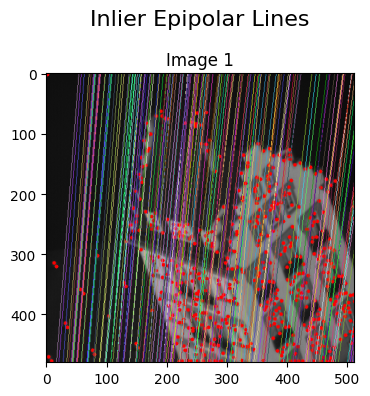

In [ ]:
# Display inlier matches

fig, ax1,  = plt.subplots(1, 1, figsize=(10, 4))
img1_inliers = img1.copy()
width = img1_inliers.shape[1]

n = len(inlierPoints1)
for i in range(n):
    x = inlierPoints1[i][0]
    y = inlierPoints1[i][0]

    if np.isnan(x) or np.isnan(y):
      continue

    # Homogenous coordinates
    matchedPoints1_h = np.array([[x], [y], [1]])

    # Epipolar lines will be in the vector (a, b, c)
    # This corresponds to ax + by + c
    expected_epipolar_line_1 = E @ matchedPoints1_h

    # Compute the epipolar distance from the point and its expected epipolar line
    line1_a = expected_epipolar_line_1[0]
    line1_b = expected_epipolar_line_1[1]
    line1_c = expected_epipolar_line_1[2]

    if np.isnan(line1_a) or np.isnan(line1_b) or np.isnan(line1_c):
      continue

    if line1_b==0:
      continue

    line1_slope = int((-line1_a/line1_b)[0])
    line1_intercept = int((-line1_c/line1_b)[0])

    cv.line(img1_inliers, (0, line1_intercept), (width, int(width*line1_slope+line1_intercept)), color=255*np.random.rand(3), thickness=1)

ax1.set_title('Image 1')
ax1.imshow(img1_inliers)

fig.suptitle('Inlier Epipolar Lines', fontsize=16)
plt.tight_layout()
plt.show()

# https://www.geeksforgeeks.org/python-opencv-cv2-line-method/

### Visulize your result (10 pts)

For visulization, you need to plot the predicted 3D locations of the tracked points. Choose the viewpoints so that the 3D structure is clearly visible.

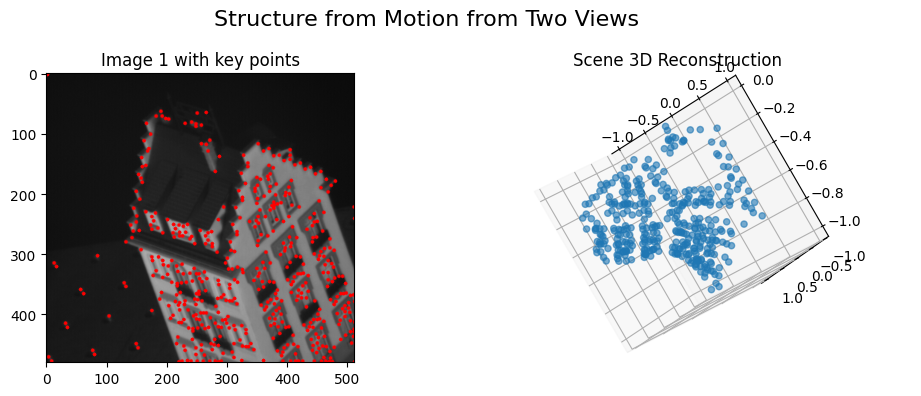

In [ ]:
# Plot the 3D points using matplotlib scatterplot3D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Display the first image with its matched points on the left
ax1.set_title('Image 1 with key points')
dir = "/content/Part2_data/images/"
img1_idx = 0
filename_prefix = f"hotel.seq"
filename_postfix = f".png"
img1_name = f"{filename_prefix}{img1_idx}{filename_postfix}"
img1_file = os.path.join(dir, img1_name)
img1 = cv2.imread(img1_file)
imagePoints1_x = data['track_x'][:, img1_idx]
imagePoints1_y = data['track_y'][:, img1_idx]
imagePoints1 = np.column_stack((imagePoints1_x, imagePoints1_y))
for i in imagePoints1:
    x,y = i
    x = int(x)
    y = int(y)
    cv.circle(img1,(x,y),3,255,-1)
ax1.imshow(img1)

# Display the 3D reconstruction of the scene on the right
ax2.set_title('Scene 3D Reconstruction')
ax2.set_axis_off()
ax2 = fig.add_subplot(122, projection='3d', alpha=0.6)
ax2.scatter(
   ( 2*(X - np.min(X)) / (np.max(X) - np.min(X))-1),
     (Y - np.min(Y)) / (np.max(Y) - np.min(Y))-1,
      (2*(Z - np.min(Z)) / (np.max(Z) - np.min(Z))-1),
   alpha=0.6
)
# Change the camera view to see the structure
ax2.view_init(elev=127, azim=180, roll=-60)


fig.suptitle('Structure from Motion from Two Views', fontsize=16)
plt.tight_layout()
plt.show()

# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html

## Report
You will be graded primarily based on your report.
A demonstration of understanding of the concepts involved in the project are required show the output produced by your code.

Include visualizations of the output of each stage in your pipeline (as shown in the system diagram on page 2), and a description of what you did for each step. Assume that we’re familiar with the project, so you don’t need to spend time repeating what’s already in the course notes. Instead, focus on any interesting problems you encountered and/or solutions you implemented.

As usual, your report must be full English sentences, **not** commented code. There is a word limit of 1500 words and no minimum length requirement.

TEST SET available **TBD on Piazza**

## Feature Tracking
The first step of this part was to implement key point selection. We used Opencv’s function goodFeaturesToTrack to extract coordinates. We implemented optical flow by writing the algorithm on the image. We first computed the change in intensities in the x and y direction by using sobel operators. Then, we implemented the Lucas Kanade algorithm. We computed (u,v) on multiple points of the image, then we shifted the window to calculate the optical flow at different places. After finding the optical flow, we generated a graph showing the key points on the left and the optical flow on the right.


## Structure from Motion from Two Views

The first step of this part was to select two images to reconstruct the structure. We tried selecting different pairs of images before our final output above. We found that some pairs generated better structures than others. We have more analysis about this at the end of the document.

Then, we loaded in the matched points of the images from the mat file given to us. After this, we generated a visualization to show the mapping of points by drawing a line between corresponding points. This is similar to the visualization in the feature mapping part of the previous project.

Using the matched points, we estimated the essential matrix by implementing the 8 point algorithm. This was done by generating a matrix A and finding the least squares solution using singular value decomposition. We followed the formula in the slides. Then, we found the inliers by using the estimated essential matrix to get epipolar lines. These epipolar lines were then compared and we only kept some as inliers. In order to be an inlier, the epipolar distance had to be minimal.

Using the essential matrix, we can generate the camera poses. Then, we used linear triangulation to get the 3D points, as shown in the slides. We had to scale the points to ensure that the points were spaced out. We have more analysis about this later in the document.

Our approach was marked by precision and attention to detail, resulting in a highly realistic 3D representation of the scene. The 3D scatter plot we created provided a vivid and accurate portrayal of the scene's structure, showcasing our successful translation of 2D image data into a meaningful 3D format.

We generated graphs for each step of this.

## Failures:
1 : Incorrect Image Selection for Structure from Motion:
At first, we selected image 20 and image 22 respectively as the two images to reconstruct the scene. However, this meant that the optical flows between the images would be very small, meaning that we weren’t able to capture enough information. This ultimately led to a very inaccurate reconstruction. However, when we expanded the range to image 0 and image 50, we got the output in the graphs above. We adjusted the camera angle to see the reconstruction in a better angle. With this selection, we can clearly see the roof of the building and the two walls, meaning that more detailed information was captured..

2: Inadequate 3D Structure Height:
In the reconstruction, the height of the house doesn’t seem to be tall enough. This could have been minimized by scaling the points, specifically the height, after estimating them through least squares. We tried scaling the x, y, z coordinates after the least squares solution through trial and error after running the points through linear triangulation.

3: Incomplete Utilization of Camera Intrinsics in Analysis

In the methods, we were given a matrix for the Intrinsics parameters of the camera. However, they were not fully used in our code. This omission might have lead to potential inconsistencies and inaccuracies in our reconstruction of the 3D structure.



# Allowed Functions

For cv2 advanced functions, only these are allowed:
1. For feature detection: **cv2.cornerHarris**, **cv2.cornerHarris**, **cv2.goodFeaturesToTrack**
2. For drawing matches: **cv2.drawMatches**

# Submission Guidelines

**If your submission does not comply with the following guidelines, you’ll be given ZERO credit.**

Your submission on ELMS(Canvas) must be a pdf file, following the naming convention **YourDirectoryID_proj2.pdf**. For example, xyz123_proj2.pdf.

**All your results and report should be included in this notebook. After you finished all, please export the notebook as a pdf file and submit it to ELMS(Canvas).**

# Collaboration Policy
You are encouraged to discuss the ideas with your peers. However, the code should be your own, and should be the result of you exercising your own understanding of it. If you reference anyone else’s code in writing your project, you must properly cite it in your code (in comments) and your writeup. For the full honor code refer to the CMSC426 Fall 2023 website.